In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

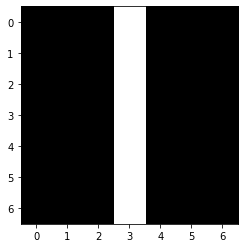

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 
filters[3, :, :, 1] = 1  
plt.imshow(filters[:,:,0,0], cmap='gray')
plt.show()

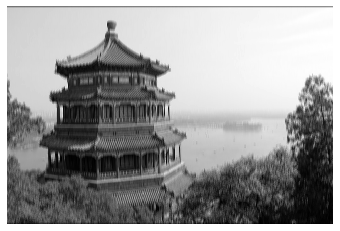

In [4]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.imshow(outputs[0, :, :, 0], cmap="gray") 
plt.axis("off") 
plt.show()

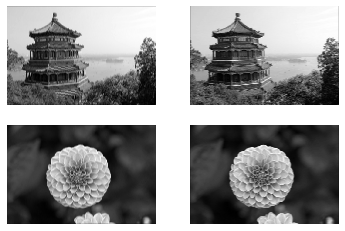

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [6]:
def crop(images):
    return images[150:220, 130:250]

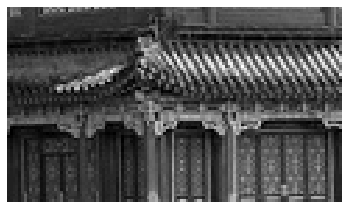

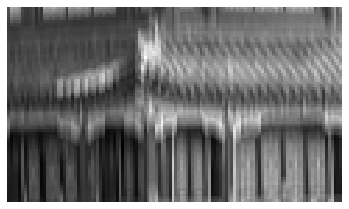

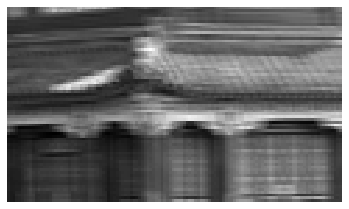

In [7]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

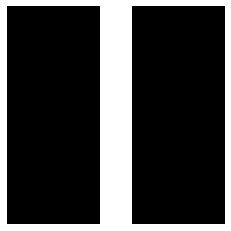

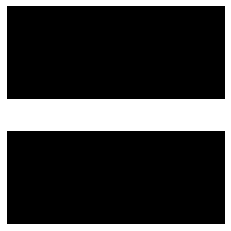

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [9]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

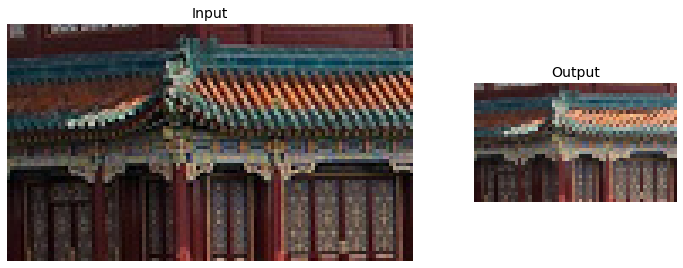

In [10]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0]) 
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0]) 
ax2.axis("off")
plt.show()

In [ ]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [21]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): 
    depth_output = depth_pool(cropped_images)
cropped_images.shape, depth_output.shape

((2, 70, 120, 3), TensorShape([2, 70, 120, 1]))

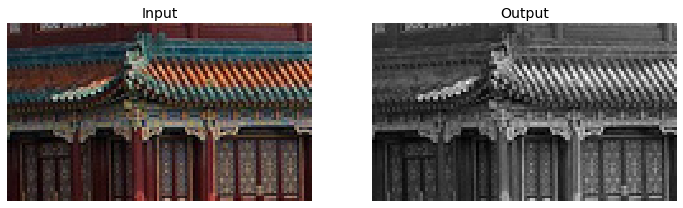

In [22]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0]) 
plt.axis("off")
plt.show()

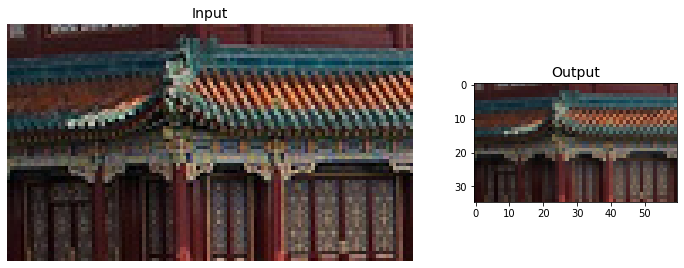

In [23]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0]) 
plt.show()

In [24]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: id=122, shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [25]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: id=125, shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [26]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [19]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [21]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
X_new = X_test[:10] 
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.2601 - accuracy: 0.9140 - val_loss: 0.2706 - val_accuracy: 0.9056
Epoch 2/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.2429 - accuracy: 0.9173 - val_loss: 0.2897 - val_accuracy: 0.8974
Epoch 3/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.2375 - accuracy: 0.9186 - val_loss: 0.2931 - val_accuracy: 0.9016
Epoch 4/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.2312 - accuracy: 0.9203 - val_loss: 0.3188 - val_accuracy: 0.9032
Epoch 5/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.2240 - accuracy: 0.9238 - val_loss: 0.3373 - val_accuracy: 0.9056


# ResNet-34

In [31]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                       padding='SAME', use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()         
        ]
        self.skip_layers=[]
        if strides>1:
            self.skip_layers=[
                DefaultConv2D(filters,kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z=inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [32]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides=1 if prev_filters==filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))   

In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_12 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_4 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_6 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_7 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_8 (ResidualUni (None, 56, 56, 64)       

In [14]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 182s 2us/step


In [27]:
images[0].shape

(427, 640, 3)

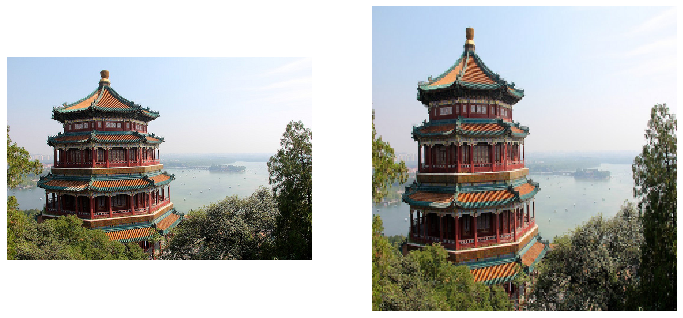

In [32]:
# Here, the aspect ratio changes according to the new shape
plt.figure(figsize=(12,18))
plt.subplot(1, 2, 1)
plot_color_image(images[0])

resized_image = tf.image.resize(images[0], size=[224,224])
plt.subplot(1, 2, 2)
plot_color_image(resized_image)
plt.show()

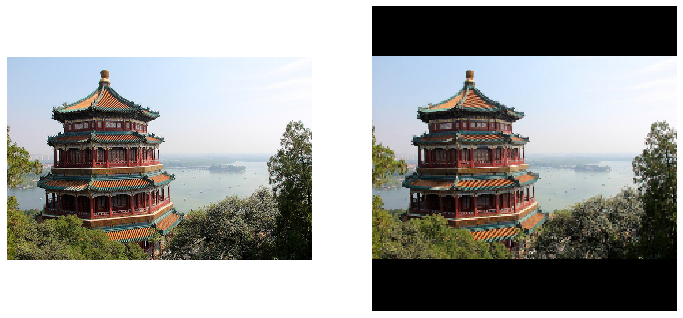

In [41]:
# To prevent the aspect ratio use resize_with_pad antialias=True 
plt.figure(figsize=(12,18))
plt.subplot(1, 2, 1)
plot_color_image(images[0])

resized_image = tf.image.resize_with_pad(images, target_height=224, target_width=224)
plt.subplot(1, 2, 2)
plot_color_image(resized_image[0])
plt.show()

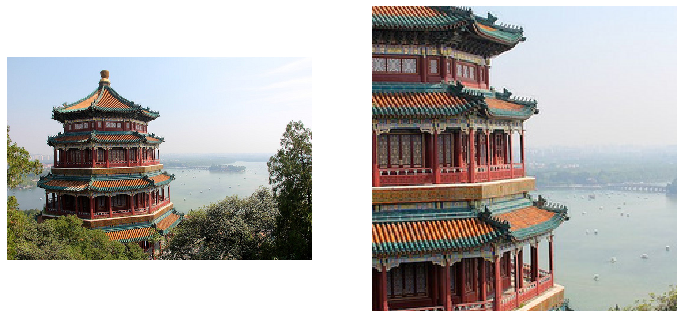

In [44]:
plt.figure(figsize=(12,18))
plt.subplot(1, 2, 1)
plot_color_image(images[0])

resized_image = tf.image.resize_with_crop_or_pad(images, target_height=224, target_width=224)
plt.subplot(1, 2, 2)
plot_color_image(resized_image[0])
plt.show()

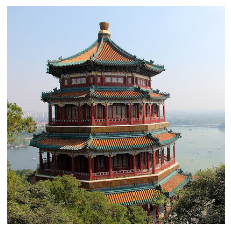

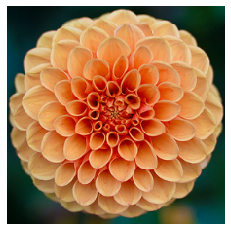

In [12]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [15]:
# Parse inputs with scale 0 to 255. to the model's preprocess_input so that it would automatically convert them to the right scale
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [16]:
Y_proba.shape

(2, 1000)

In [17]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 3s 72us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



In [ ]:
info.splits['train']

In [73]:
class_names = info.features['label'].names
class_names

NameError: name 'info' is not defined

In [74]:
n_classes = info.features["label"].num_classes

NameError: name 'info' is not defined

In [75]:
dataset_size = info.splits["train"].num_examples
dataset_size

NameError: name 'info' is not defined

In [78]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True)

ConnectionError: Failed to construct dataset tf_flowersHTTPSConnectionPool(host='storage.googleapis.com', port=443): Max retries exceeded with url: /tfds-data/?prefix=dataset_info/tf_flowers/3.0.0/ (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001D2CD0D8E88>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [79]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

NameError: name 'train_set_raw' is not defined

<Figure size 864x720 with 0 Axes>

In [80]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [81]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

NameError: name 'train_set_raw' is not defined

In [82]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

NameError: name 'train_set' is not defined

<Figure size 864x864 with 0 Axes>

In [83]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

NameError: name 'test_set' is not defined

<Figure size 864x864 with 0 Axes>

In [85]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [86]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [87]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [88]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

NameError: name 'train_set' is not defined

In [89]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

NameError: name 'train_set' is not defined

# Classification with Localization

In [90]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

NameError: name 'n_classes' is not defined

In [91]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

NameError: name 'train_set' is not defined

In [9]:
precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
np.flip(precisions)

array([0.1 , 0.2 , 0.45, 0.6 , 0.8 , 0.92, 0.95, 0.94, 0.96, 0.94, 0.91])

In [7]:
np.maximum.accumulate(np.flip(precisions))

array([0.1 , 0.2 , 0.45, 0.6 , 0.8 , 0.92, 0.95, 0.95, 0.96, 0.96, 0.96])

In [8]:
np.flip(np.maximum.accumulate(np.flip(precisions)))

array([0.96, 0.96, 0.96, 0.95, 0.95, 0.92, 0.8 , 0.6 , 0.45, 0.2 , 0.1 ])

In [10]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

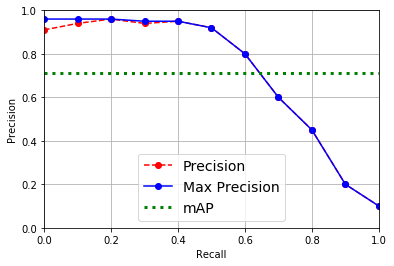

In [11]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

In [16]:
tf.random.set_seed(42)
X = images_resized.numpy()
X.shape

(2, 224, 224, 3)

In [18]:
conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

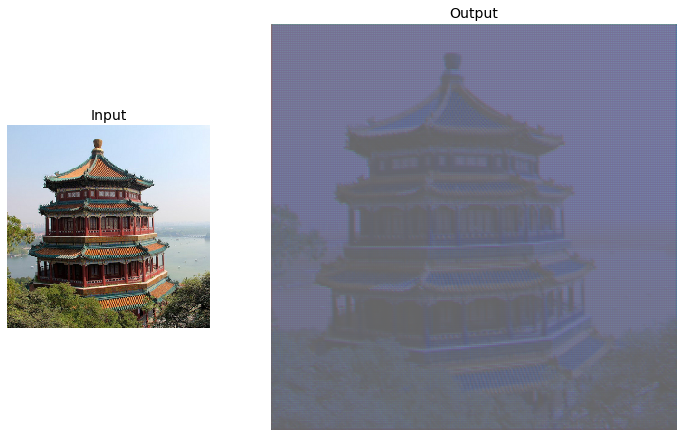

In [39]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic") 
ax2.axis("off")
plt.show()

In [38]:
output[0, ...].shape

TensorShape([449, 449, 5])

In [40]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [46]:
a= tf.random.uniform([2,4])
a

<tf.Tensor: id=327, shape=(2, 4), dtype=float32, numpy=
array([[0.7402308 , 0.33938193, 0.5692506 , 0.44811392],
       [0.29285502, 0.4260056 , 0.62890387, 0.691061  ]], dtype=float32)>

In [51]:
np.flip(a, axis=[0, 1])

<tf.Tensor: id=347, shape=(2, 4), dtype=float32, numpy=
array([[0.691061  , 0.62890387, 0.4260056 , 0.29285502],
       [0.44811392, 0.5692506 , 0.33938193, 0.7402308 ]], dtype=float32)>

In [43]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
weights.shape

TensorShape([3, 3, 5, 3])

In [55]:
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")
upscaled.shape, manual_output.shape

((2, 451, 451, 3), TensorShape([2, 449, 449, 5]))

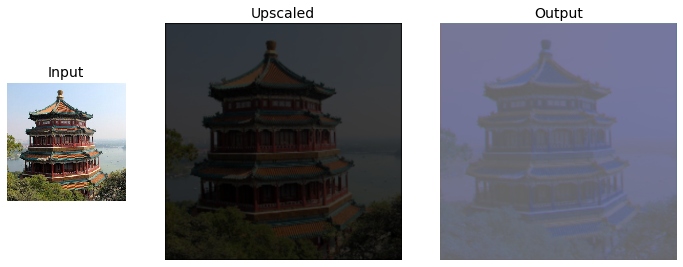

In [42]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()